# TSIA202a - Third Practice Session

The goal of this third partical work is to use an AR(p) process to model a speech signal, and show that this approch is surprisingly powerful despite its simplicity.

The proposed synthesis algorithm divides into several steps.
1. Filter the audio signal to emphasize the highest frequencies (in order to flatten the spectrum and reduce precision issues with FFT computations).
2. Split the signal into several overlapping frames and iterate over them.
    1. Detect if the frame corresponds to noise or to a voiced signal, and estimate the fundamental frequency in the later case.
    2. Estimate the AR(p) coefficients using Yule-Walker equations.
    3. Re-synthetise the frame using the AR(p) coefficients, starting from a white noise in the case of a noisy frame, or a Dirac comb in the case of a voiced frame.
3. Overlap-add the synthesized frames with a Hanning window.
4. Filter the synthesised signal to de-emphasize the highest frequencies.

We propose to implement this algorithm in two parts. First, we will derive the Yule-Walker equations, and test them on synthetic data. Then, we will code the synthesis algorithm and apply it on a real world speech signal.


# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma_2 \; 0 \; \ldots \; 0]^T 
\end{equation}
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.

# 3. Speech modeling

We will now implement the synthesis algorithm and evaluate it on a speech signal. 

A code template is provided below. We will use the file audio.wav to test the algorithm. 


Listen to the original and synthesized signal by using any audio player. Try to modify the pitch of the synthesised signal and listen to the result.


# 1. Yule-Walker equations


$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t
$$

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0 $:
$$
\begin{align*}
\mathbb{E}[X_{t-h}Z_t] &= \mathbb{E}[\phi_1 X_{t-h-1}Z_t + \phi_2 X_{t-h-2}Z_t + \ldots + \phi_p X_{t-h-p}Z_t + Z_t Z_t] \\
&= \phi_1 \mathbb{E}[X_{t-h-1}Z_t] + \phi_2 \mathbb{E}[X_{t-h-2}Z_t] + \ldots + \phi_p \mathbb{E}[X_{t-h-p}Z_t] + \mathbb{E}[Z_t^2] \\
&= 0 + 0 + \ldots + 0 + \mathbb{E}[Z_t^2] \\
&= 0
\end{align*}
$$

2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$:
$$
\begin{align*}
\gamma(h) &= \mathbb{E}[(X_t - \mu)(X_{t-h} - \mu)] \\
&= \mathbb{E}\left[\left(\sum_{i=1}^{p}\phi_i X_{t-i} + Z_t - \mu\right)\left(\sum_{j=1}^{p}\phi_j X_{t-h-j} + Z_{t-h} - \mu\right)\right] \\
&= \sum_{i=1}^{p}\sum_{j=1}^{p}\phi_i\phi_j\gamma(h+i-j) + \sum_{i=1}^{p}\phi_i\gamma(h-i) + \sum_{j=1}^{p}\phi_j\gamma(h-j) + \sigma^2\delta(h)
\end{align*}
$$

3. We consider separately the case h=0: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$:
$$
\begin{align*}
\gamma(0) &= \sum_{i=1}^{p}\phi_i\gamma(-i) + \sigma^2
\end{align*}
$$

4. Put these relationships in matrix form:
$$
\Gamma_{p+1} \mathbf{a} = \mathbf{r}
$$

where:

$$
\Gamma_{p+1} = \begin{bmatrix}
\gamma(0) & \gamma(1) & \cdots & \gamma(p) \\
\gamma(1) & \gamma(0) & \cdots & \gamma(p-1) \\
\vdots & \vdots & \ddots & \vdots \\
\gamma(p) & \gamma(p-1) & \cdots & \gamma(0)
\end{bmatrix}
$$

$$
\mathbf{a} = \begin{bmatrix}
1 \\
-\phi_1 \\
\vdots \\
-\phi_p
\end{bmatrix}
$$

$$
\mathbf{r} = \begin{bmatrix}
\sigma^2 \\
0 \\
\vdots \\
0
\end{bmatrix}
$$


In [34]:
## imports

import librosa
import soundfile as sf
import scipy
import numpy as np
import math
from IPython.display import Audio
from collections import defaultdict
from tqdm import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.


    Question 1

In [35]:
import random
num_samples = 1000

sigma = 2
variance = sigma**2

WN = np.random.normal(0, np.sqrt(variance), num_samples)

# generate the 
min_coefficient = -1.0
max_coefficient = 1.0

# Generate four random coefficients
coefs = [0.4, -0.1, 0.1, 0.2]
print(coefs)

[0.4, -0.1, 0.1, 0.2]


In [36]:
## Build X an AR(4)

X = np.zeros(num_samples)
X[0] = WN[0]
X[1] = X[0] * coefs[0]+WN[1]
X[2] = X[1] * coefs[1]+X[0] * coefs[0]+WN[2]
X[3] = X[2] * coefs[2]+ X[1] * coefs[1]+X[0] * coefs[0]+WN[3]

for i in range(4,num_samples):
    X[i]= X[i-4] * coefs[3]+ X[i-3] * coefs[2]+ X[i-2] * coefs[1]+ X[i-1] * coefs[0]+ WN[i]

    Question 2

In [37]:
# Computing Empirical autocovariance : 

"""
    Parameters:
    V : The vector for which we want to compute the empirical autocovariance.
    a : The start index of the interval (inclusive).
    b : The end index of the interval (inclusive).
    h : The lag for which we want to compute the autocovariance.
    empirical_mean (float): The empirical mean of the input vector V.
    Returns:
    S : The sum of products of differences required for computing the empirical autocovariance.
"""
def sum_cov(V, a, b, h, empirical_mean):
    return sum((V[i + h] - empirical_mean) * (V[i] - empirical_mean) for i in range(a, b + 1))



# the principale function to compute the empirical autocovaraince : 
def compute_emp_cov(V, h, empirical_mean, T):
    if 0 <= h <= T - 1:
        return T**(-1) * sum_cov(V, 0, T - h - 1, h, empirical_mean)
    elif 0 >= h >= 1 - T:
        return T**(-1) * sum_cov(V, 1 - h - 1, T - 1, h, empirical_mean)
    else:
        return 0

In [38]:
# Estimation of the autocorreclaation matrix using correlate function :

# Generating the matrix Gamma
def gamma_matrix(A, n):
    Gamma = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            Gamma[i][j] = compute_emp_cov(A,i - j, sum(A) / len(A), len(A))
    return Gamma


Gamma_ = gamma_matrix(X, 5)
print(Gamma_)

[[4.90672553 1.85242014 0.26453038 0.68546138 1.36527206]
 [1.85242014 4.90672553 1.85242014 0.26453038 0.68546138]
 [0.26453038 1.85242014 4.90672553 1.85242014 0.26453038]
 [0.68546138 0.26453038 1.85242014 4.90672553 1.85242014]
 [1.36527206 0.68546138 0.26453038 1.85242014 4.90672553]]


    Question 3

In [39]:
Gamma_inverse = np.linalg.pinv(Gamma_)
vector = np.zeros(5)
vector[0] = variance

coef_estimation = np.dot(Gamma_inverse, vector)
coef_estimation = coef_estimation[1:]
print("Estimation  : " ,coef_estimation)
print(" real coeficients : ",coefs)

Estimation  :  [-0.41332965  0.15023468 -0.10375714 -0.19858662]
 real coeficients :  [0.4, -0.1, 0.1, 0.2]


In [40]:
# True values for comparison
_error = np.abs((coefs - coef_estimation)**2)
print("Error : ", _error)

Error :  [0.66150512 0.06261739 0.04151697 0.1588713 ]


    Question 4

To estimate the power spectral distribution of the synthesized signal, we will use the periodogram function written in the Lab 2, let's import it :

In [41]:
import numpy as np

def periodogram_def(X, m, n):
    ''' Compute the periodogram of the observations X.
    Parameters
    ----------
    X : Observations
    m : int
        Number of frequencies to compute (Length of the transformed axis of the output.)
    n : int
        Number of observations.
    Returns
    -------
    I_values : numpy.ndarray, shape=(m,)
        Periodogram values.
    '''
    # Compute the DFT if the observations
    DFT_X = np.fft.fft(X, m)
    
    # Compute the periodogram
    I_values = ( (np.abs(DFT_X) ** 2 )/ (2 * np.pi * n) )

    # I_n(2πk/m) is I_values[k]
    return I_values

In [42]:
m = 1000
power_spectrum = periodogram_def(X, m, num_samples)

k = 12
# I_n(2πk/m) is periodogram[k]
print(power_spectrum[k])

2.8804635840698554


Now let's compute the theoretical distribution :  

In [43]:
# theoritical the power density:
def periodogram_theoritical(coefs, m, variance):
    F = []
    for k in range(m):
        Phi = 0
        for i in range(3):
            Phi += coefs[i] * np.exp(-1j * 2 * np.pi * k * i / m)
        F.append(variance/ (2 * np.pi* (abs(Phi)**2)))
    return F

m = 1000
theo_power_density = periodogram_theoritical(coefs, m, variance)

In [44]:
# Calculating the MSE for the first 1000 values of the power spectrum :
C = 0
MSE = 0
for k in range(1000):
    MSE = (power_spectrum[k] - theo_power_density[k])**2

print(MSE / 1000)

0.004018591907762333


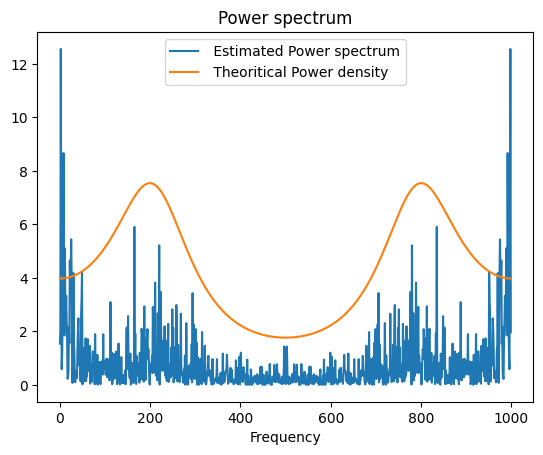

In [45]:
# plotting the power spectrum and the power density :

plt.plot(power_spectrum, label = ' Estimated Power spectrum')
plt.xlabel('Frequency')
plt.plot(theo_power_density, label = ' Theoritical Power density')
plt.title("Power spectrum")
plt.legend()
plt.show()

### 3. Speech modeling : 

In [46]:
## hyperparameters

sampling_rate = 8000 # (Hz)
frame_duration = 0.04 # duration of the analysis frames (seconds)
overlap_ratio = 0.5 # overlap ratio between two consecutive analysis frames
p = 12 # AR(p) model order
f_min = 80 # minimum frequency for pitch detection (Hz)
f_max = 400 # maximum frequency for pitch detection Hz)
pitch_detection_threshold = 0.5 # threshold for pitch detection

In [47]:
## synthesis

# load audio
x = librosa.load('audio.wav', sr=sampling_rate)[0]

## Audio(x, rate=sampling_rate)

# pre-emphasis filtering
x = scipy.signal.lfilter([1, -0.98], [1], x)

# handy variables
n_frame = math.floor(len(x) / (sampling_rate * frame_duration * (1 - overlap_ratio))) - 1 # discard last frame
frame_length = int(sampling_rate * frame_duration)
min_period = math.floor(sampling_rate / f_max)
max_period = math.ceil(sampling_rate / f_min)
synthesis = np.zeros(len(x))
log_dict = defaultdict(list)

# loop over frames
for frame_index in tqdm(range(n_frame)):

    # extract frame
    start = int(frame_index * sampling_rate * frame_duration * (1 - overlap_ratio))
    end = start + frame_length
    frame = x[start:end]

    # detect pitch
    auto_covariance = np.fft.irfft(np.abs(np.fft.rfft(frame - np.mean(frame), (2*frame_length-1)))**2 / frame_length)[:frame_length]
    pitch, max_value = auto_covariance[min_period:].argmax() + min_period, auto_covariance[min_period:].max() / auto_covariance[0]
    if (pitch > max_period) or (max_value * frame_length / (frame_length - pitch) < pitch_detection_threshold): # detect silent frame 
        pitch = 0
    
    # estimate AR(p) coefficients
    gamma = gamma_matrix(frame, p+1)
    v = np.array([1 if k==0 else 0 for k in range(p+1)])
    coefficient = np.dot(np.linalg.pinv(gamma), v)
    sigma =1 / np.sqrt(np.dot(np.linalg.pinv(gamma), v)[0])
    coefficient = (sigma **2 )* coefficient[:]
    
    # re-synthetise frame
    if pitch == 0:
        noise = np.random.normal(0, np.sqrt(sigma), frame_length + p)
        frame_r = scipy.signal.lfilter([1], coefficient, noise)
    else:
        dirac_comb = [1 if k % pitch == 0 else 0 for k in range(frame_length + p)]
        frame_r = scipy.signal.lfilter([1], coefficient, dirac_comb)
    frame_r = frame_r[p:]
    normalization_factor = np.sqrt(sigma / np.var(frame_r))
    frame_r = normalization_factor * frame_r[:frame_length]

    # overlap-add
    synthesis[start:end] += frame_r * np.hanning(frame_length)

    # compute power spectral density (for logging purposes)
    original_psd = periodogram_theoritical(coefficient, m, sigma**2)
    synthesis_psd = periodogram_def(frame, m, frame_length)  

    # log
    log_dict["frame"].append(frame)
    log_dict["pitch"].append(pitch)
    log_dict["sigma"].append(sigma)
    log_dict["coefficient"].append(coefficient)
    log_dict["frame_r"].append(frame_r)
    log_dict["original_psd"].append(original_psd)
    log_dict["synthesis_psd"].append(synthesis_psd)

# de-emphasis filtering
synthesis = scipy.signal.lfilter([1], [1, -0.98], synthesis)

# log
sf.write('synthesis.wav', synthesis, sampling_rate)
log_dict["synthesis"].append(synthesis)
log_dict = {k: np.array(v) for k, v in log_dict.items()}

100%|██████████| 279/279 [00:09<00:00, 30.78it/s]


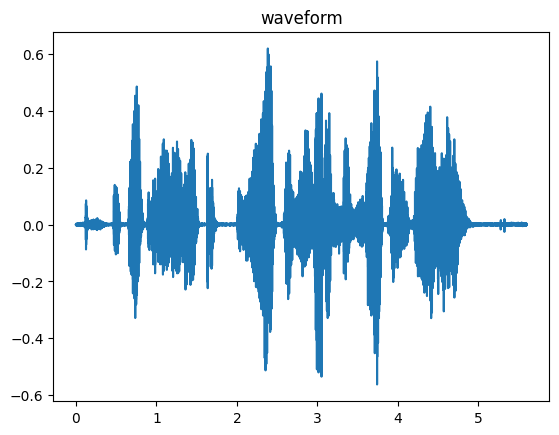

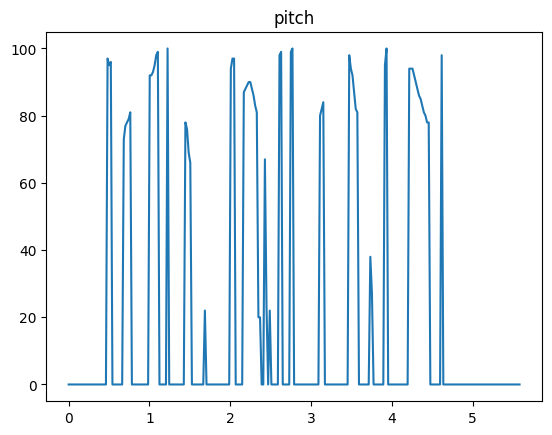

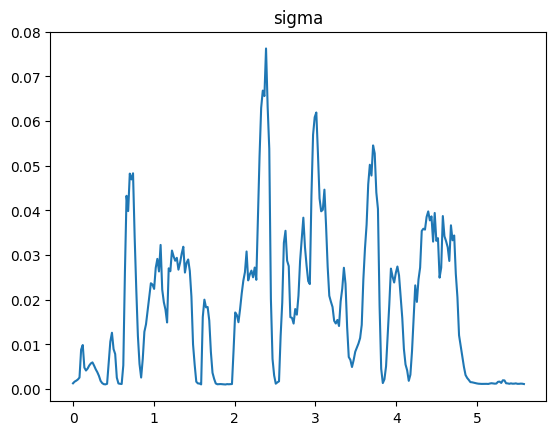

In [48]:
## plot

# time axis for plotting
sample_time = np.linspace(0, len(x)/sampling_rate, len(x))
frame_time = np.linspace(0, n_frame*frame_duration*(1-overlap_ratio), n_frame)

# waveform
plt.title("waveform")
plt.plot(sample_time, x)
plt.show()

# pitch
plt.title("pitch")
plt.plot(frame_time, log_dict["pitch"])
plt.show()

# variance
plt.title("sigma")
plt.plot(frame_time, log_dict["sigma"])
plt.show()

# power spectral density
fig, ax = plt.subplots()
fig.suptitle("estimated & theoretical spectral density")
y_min = min(log_dict["original_psd"].min(), log_dict["synthesis_psd"].min())
y_max = max(log_dict["original_psd"].max(), log_dict["synthesis_psd"].max())
def animate(i):
    ax.cla()
    ax.set_ylim([y_min-0.1, y_max+0.1])
    ax.plot(log_dict["original_psd"][i], label="original_psd")
    ax.plot(log_dict["synthesis_psd"][i], label="synthesis_psd")
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(log_dict["original_psd"]))
display(HTML(animation.to_jshtml()))
plt.close()